# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68 + 3005 examples of length=130 and scoring_length=91
- private leaderboard test set: 3005 examples of length=130 and scoring_length=91 OR same as public test set ????????????????????

### TODO:
- no testing model, one model with different testing and training outputs
- augmentation
- przewidywanie dalszego fragmentu sekwencji na podstawie wczesiejszego fragmentu sekwencji
- GCN
- sequence fragmentation and similarieties finding

## Import section

In [272]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import uuid
import copy
import random

In [232]:
%load_ext tensorboard

In [233]:
%load_ext autoreload
%autoreload 2

from ipynb.draw import draw_struct

# Data Loading

In [60]:
os.getcwd()

'/home/jan/kaggle_competitions/covid'

In [215]:
raw_train_valid_ds = pd.read_json('./train.json', lines=True)
raw_test_ds = pd.read_json('./test.json', lines=True)
sample_submission = pd.read_csv('./sample_submission.csv')

In [216]:
def struct2adjmatrix(structure):
    N = len(structure)
    adjacency_matrix = lil_matrix((N,N))
    stack = []
    for i, symbol in enumerate(structure):
        if symbol == '.':
            continue
        elif symbol == '(':
            stack.append(i)
        elif symbol == ')':
            j = stack.pop()
            adjacency_matrix[i,j] = 1
            adjacency_matrix[j,i] = 1
    return adjacency_matrix.tocsr()  

def add_adjacency_matrix_column(raw_ds):
    raw_ds.insert(4, 'adjacency_matrix', None)
    raw_ds['adjacency_matrix'] = raw_ds['structure'].map(lambda structure: struct2adjmatrix(structure).toarray())

In [217]:
add_adjacency_matrix_column(raw_train_valid_ds)
add_adjacency_matrix_column(raw_test_ds)

### Data inspection

In [218]:
def raw_ds_summary(raw_ds):
    print('EXAMPLES:')
    display(raw_ds.head())
    print()
    print('SIMPLE STATISTICS:')
    display(raw_ds.describe())
    print()
    print('POSSIBLE SEQUENCES LENGTHS')
    display(raw_ds[['seq_length', 'seq_scored']].drop_duplicates())

In [219]:
print('RAW_TRAIN_VALID_DATASET')
raw_ds_summary(raw_train_valid_ds)

RAW_TRAIN_VALID_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0


SIMPLE STATISTICS:


,index,signal_to_noise,SN_filter,seq_length,seq_scored
count,2400.000000,2400.000000,2400.000000,2400.0,2400.0
mean,1199.500000,4.530456,0.662083,107.0,68.0
std,692.964646,2.835142,0.473099,0.0,0.0
min,0.000000,-0.103000,0.000000,107.0,68.0
25%,599.750000,2.391000,0.000000,107.0,68.0
50%,1199.500000,4.442500,1.000000,107.0,68.0
75%,1799.250000,6.294250,1.000000,107.0,68.0
max,2399.000000,17.194000,1.000000,107.0,68.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68


In [220]:
print('RAW_TEST_DATASET')
raw_ds_summary(raw_test_ds)

RAW_TEST_DATASET
EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,3634.000000,3634.000000,3634.000000
mean,1816.500000,126.018987,87.018987
std,1049.189767,8.702624,8.702624
min,0.000000,107.000000,68.000000
25%,908.250000,130.000000,91.000000
50%,1816.500000,130.000000,91.000000
75%,2724.750000,130.000000,91.000000
max,3633.000000,130.000000,91.000000



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68
1,130,91


### Test dataset split
Split test data into private and public datasets based on sequence lengths

In [221]:
raw_public_test_ds = raw_test_ds.loc[raw_test_ds['seq_length']==107]
raw_private_test_ds = raw_test_ds.loc[raw_test_ds['seq_length']==130]

In [222]:
raw_ds_summary(raw_public_test_ds)

EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
18,18,id_00ca60e44,GGAAAGCAGGAGGCCGAGGAUCCUGCGCUAUGAGGAAACCAUAGAC...,.....((.((.((.((.(((((((((((((((.(....)))))).)...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSBSSISSISSISSSSSSSSSSSSSSSBSHHHHSSSSSSBS...,107,68
23,23,id_00e99b69c,GGAAAUUUUAGAUUGCACACAGUCAGGUAGUUAAAAUUAGGCCACC...,..........(((((....)))))((((.(((....(((((........,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEEEESSSSSHHHHSSSSSSSSSISSSIIIISSSSSHHHHH...,107,68



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,629.000000,629.0,629.0
mean,1798.036566,107.0,68.0
std,1043.635572,0.0,0.0
min,0.000000,107.0,68.0
25%,870.000000,107.0,68.0
50%,1851.000000,107.0,68.0
75%,2683.000000,107.0,68.0
max,3627.000000,107.0,68.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
0,107,68


In [223]:
raw_ds_summary(raw_private_test_ds)

EXAMPLES:


,index,id,sequence,structure,adjacency_matrix,predicted_loop_type,seq_length,seq_scored
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91
5,5,id_002852873,GGAAAGCGAAACGCCGAGAAGACGUAGUUCGCAGAGCGGCGUACCC...,.....(((...(((......(((((((((.((....(((.....))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSIIISSSBBBBBBSSSSSSSSSBSSBBBBSSSHHHHHSS...,130,91
6,6,id_0031191b7,GGAAAUGUCUACAUAGGAGUGCUGCGGGACGGUAACGUCAUGACCG...,........(((((((((((.((..(((((((....))))....)))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEEEEESSSSSSSSSSSISSIISSSSSSSHHHHSSSSBBBBSSS...,130,91
7,7,id_003ab2445,GGAAAGACUCAGAGGUGAAGGUCAUCACGGCUGAUAGGAGACUAUC...,.....(((((..........((((((.((.(((((((....)))))...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",EEEEESSSSSBBBBBBBBBBSSSSSSISSISSSSSSSHHHHSSSSS...,130,91



SIMPLE STATISTICS:


,index,seq_length,seq_scored
count,3005.000000,3005.0,3005.0
mean,1820.364725,130.0,91.0
std,1050.480524,0.0,0.0
min,1.000000,130.0,91.0
25%,911.000000,130.0,91.0
50%,1808.000000,130.0,91.0
75%,2732.000000,130.0,91.0
max,3633.000000,130.0,91.0



POSSIBLE SEQUENCES LENGTHS


,seq_length,seq_scored
1,130,91


In [224]:
sample_submission

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.0,0.0,0.0,0.0,0.0
457949,id_ffda94f24_126,0.0,0.0,0.0,0.0,0.0
457950,id_ffda94f24_127,0.0,0.0,0.0,0.0,0.0
457951,id_ffda94f24_128,0.0,0.0,0.0,0.0,0.0


In [225]:
feature_names = ['sequence', 'structure', 'predicted_loop_type', 'adjacency_matrix']
error_label_names = ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names = error_label_names + normal_label_names
scored_label_names = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

### Raw examples visualization

In [229]:
def draw_raw_example(example, **kwargs):
    sequence = example['sequence']
    structure = example['structure']
    seq_length = example['seq_length']
    seq_scored = example['seq_scored']
    seq_not_scored = seq_length - seq_scored
    draw_struct(sequence, structure, alpha = np.concatenate([np.ones(seq_scored),0.3*np.ones(seq_not_scored)]), **kwargs)
    
def draw_random_raw_examples(raw_ds, examples_no=5):
    example_indices = random.sample(range(len(raw_ds)), examples_no)
    plot_size = 15
    fig, axes = plt.subplots(1,examples_no,figsize=(plot_size*examples_no,plot_size))
    for i, ax in enumerate(axes.flat):
        draw_raw_example(raw_ds.iloc[example_indices[i],:], ax=ax)

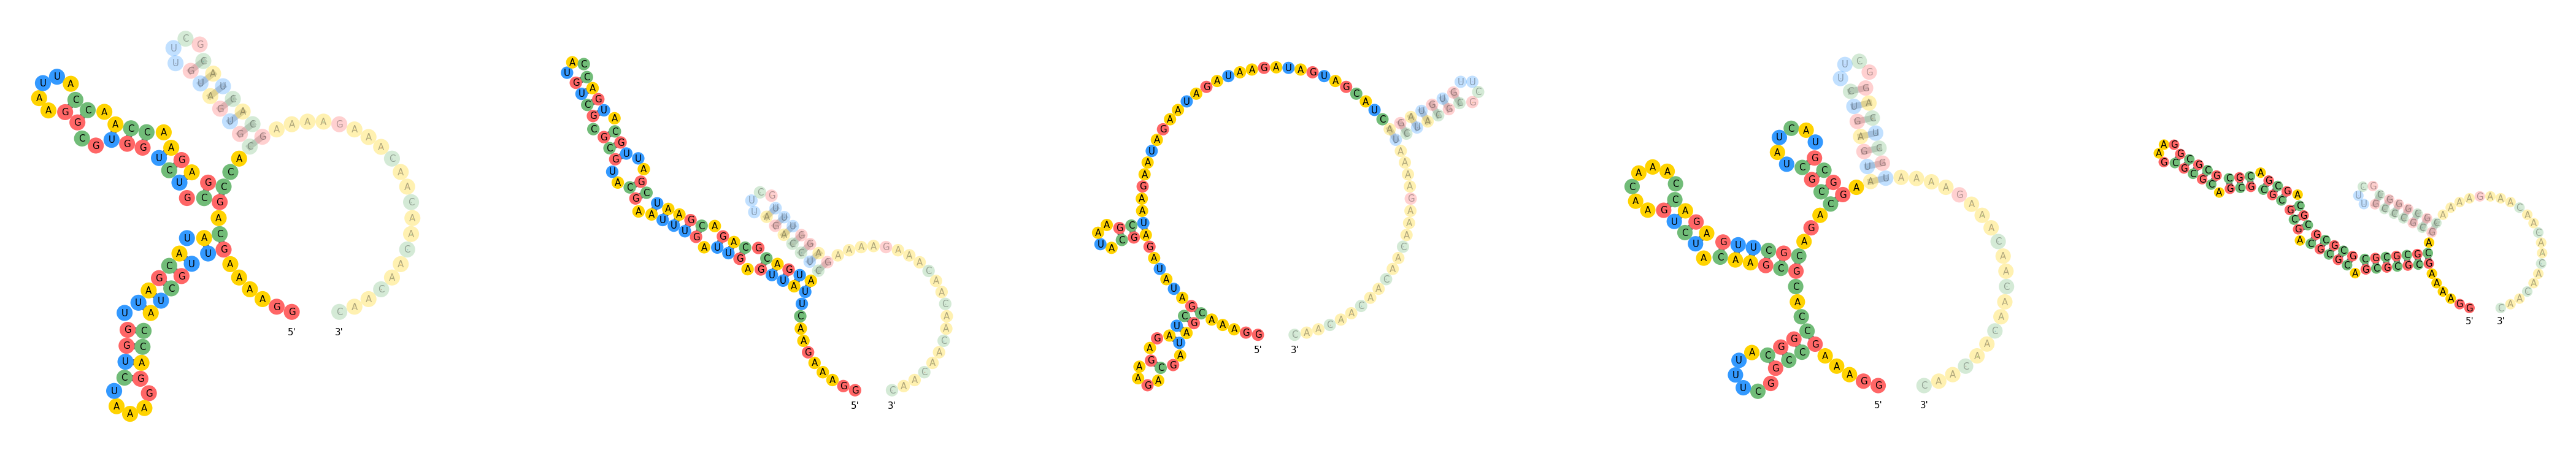

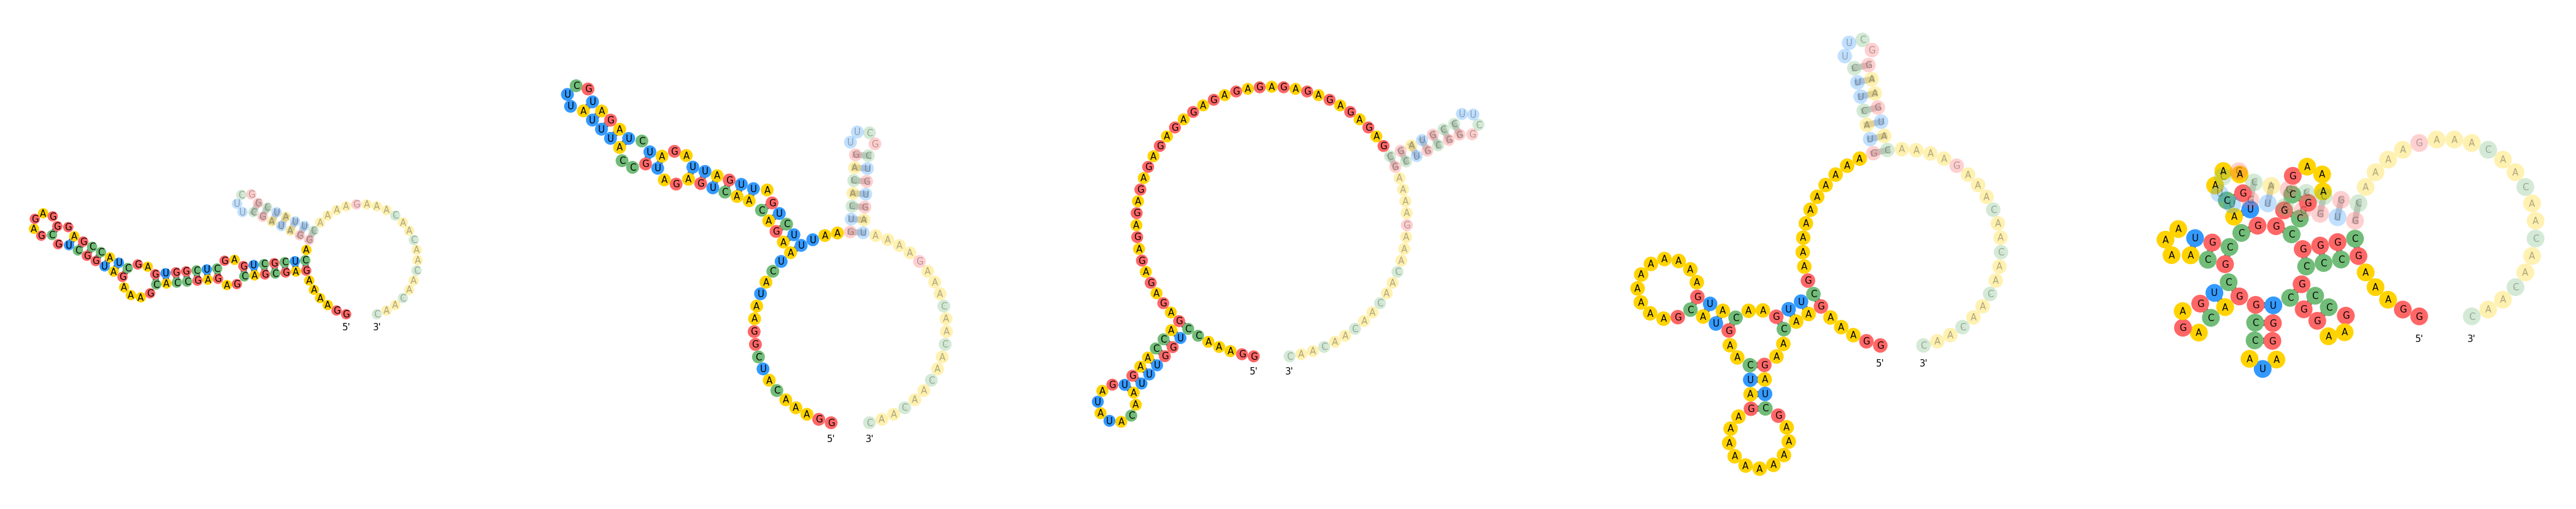

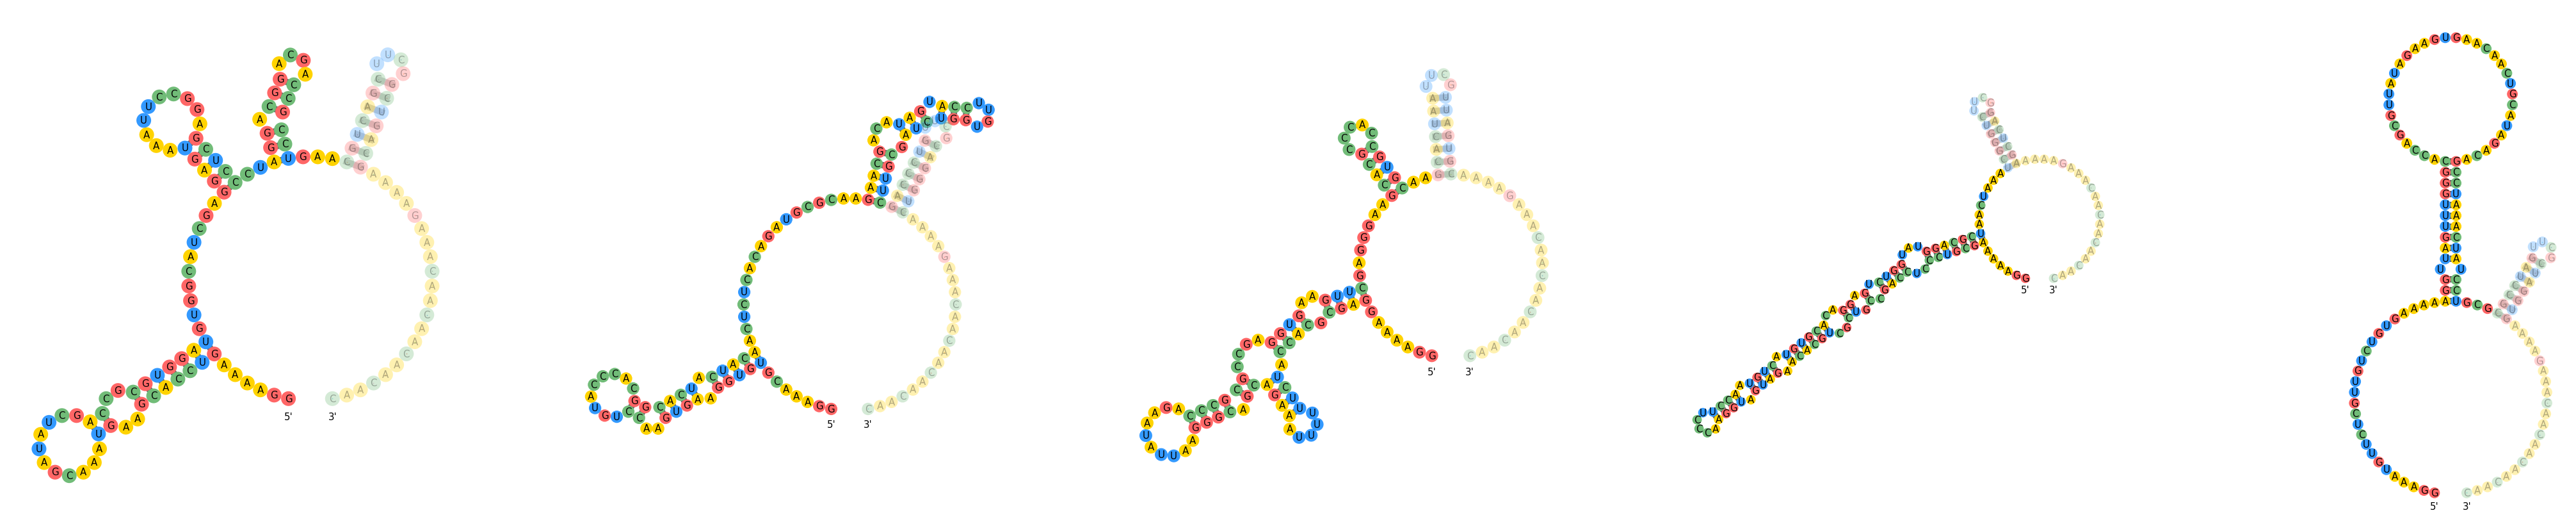

In [236]:
draw_random_raw_examples(raw_train_valid_ds)
draw_random_raw_examples(raw_public_test_ds)
draw_random_raw_examples(raw_private_test_ds)

# Structured tf.data.Dataset construction

In [237]:
class LabelsEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, labels):
        self.labels = labels

    def fit(self, X, y=None, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        X = X.apply(self.transform_example, axis='columns')
        return X

    def transform_example(self, example):
        for label in self.labels:
            example[label] = np.array(example[label], dtype=np.float32)
        return example

In [238]:
class FeaturesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.base2vec = {'A': [1,0,0,0],
                         'C': [0,1,0,0],
                         'G': [0,0,1,0],
                         'U': [0,0,0,1]}
        self.structpart2vec = {'.': [1,0,0],
                               '(': [0,1,0],
                               ')': [0,0,1]}
        self.looptype2vec = {'S': [1,0,0,0,0,0,0],
                             'M': [0,1,0,0,0,0,0],
                             'I': [0,0,1,0,0,0,0],
                             'B': [0,0,0,1,0,0,0],
                             'H': [0,0,0,0,1,0,0],
                             'E': [0,0,0,0,0,1,0],
                             'X': [0,0,0,0,0,0,1]}

    def fit(self, X, y=None, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        X = X.apply(self.transform_example, axis='columns', result_type='expand')
        return X

    def transform_example(self, example):
        encoded_sequence = [self.base2vec[base] for base in example['sequence']]
        example['sequence'] = encoded_sequence
        
        enocded_structure = [self.structpart2vec[structpart] for structpart in example['structure']]
        example['structure'] = enocded_structure
        
        enocded_loop_type = [self.looptype2vec[looptype] for looptype in example['predicted_loop_type']]
        example['predicted_loop_type'] = enocded_loop_type
        
        return example

In [239]:
class AdjacencyMatrixEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None, *args, **kwargs):
        return self
    
    def transform(self, X, *args, **kwargs):
        for title in self.titles:
            X.insert(len(X.columns), title, 0)
        X = X.apply(self.set_titles, axis='columns')
        X.drop(columns = ['Name'], inplace=True)
        return X

In [240]:
def create_train_valid_ds(raw_train_valid_ds, feature_names, all_label_names):
    # Transform dataframe using encoders
    preprocessing = make_column_transformer(
    (make_pipeline(FeaturesEncoder()),              feature_names),
    (make_pipeline(LabelsEncoder(all_label_names)), all_label_names),
    )

    data = pd.DataFrame(preprocessing.fit_transform(raw_train_valid_ds))
    data.columns = feature_names + all_label_names

    # Split into features and labels and convert to dictionaries of tensors
    features_dict = data[feature_names].to_dict(orient='list')
    for column, values in features_dict.items():
        features_dict[column] = tf.constant(values, dtype=tf.float32)

    labels_dict = data[all_label_names].to_dict(orient='list')
    for column, values in labels_dict.items():
        labels_dict[column] = tf.constant(values, dtype=tf.float32)

    # Create tf.data.Dataset
    train_valid_ds = tf.data.Dataset.from_tensor_slices((features_dict, labels_dict))

    return train_valid_ds

In [241]:
train_valid_ds = create_train_valid_ds(raw_train_valid_ds, feature_names, all_label_names)

In [242]:
def create_test_ds(raw_test_ds, feature_names):
    # Transform dataframe using encoders
    preprocessing = make_column_transformer(
    (make_pipeline(FeaturesEncoder()),feature_names)
    )

    data = pd.DataFrame(preprocessing.fit_transform(raw_test_ds))
    data.columns = feature_names

    # Split into features and labels and convert to dictionaries of tensors
    features_dict = data[feature_names].to_dict(orient='list')
    for column, values in features_dict.items():
        features_dict[column] = tf.constant(values, dtype=tf.float32)

    # Create tf.data.Dataset
    test_ds = tf.data.Dataset.from_tensor_slices(features_dict)

    return test_ds

In [243]:
public_test_ds = create_test_ds(raw_public_test_ds, feature_names)
private_test_ds = create_test_ds(raw_private_test_ds, feature_names)

### Inspect tf.data.Dataset's
Output is quite long so uncomment if needed

In [244]:
def ds_summary(ds, name):
    print(f"{name}")
    print(ds)
    print(f"Cardinality: {ds.cardinality()}")
    print('\n')
    print(f"{name} example")
    print(next(iter(ds)))

In [245]:
ds_summary(train_valid_ds, 'public_test_ds')

public_test_ds
<TensorSliceDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, {reactivity_error: (68,), deg_error_Mg_pH10: (68,), deg_error_pH10: (68,), deg_error_Mg_50C: (68,), deg_error_50C: (68,), reactivity: (68,), deg_Mg_pH10: (68,), deg_pH10: (68,), deg_Mg_50C: (68,), deg_50C: (68,)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}, {reactivity_error: tf.float32, deg_error_Mg_pH10: tf.float32, deg_error_pH10: tf.float32, deg_error_Mg_50C: tf.float32, deg_error_50C: tf.float32, reactivity: tf.float32, deg_Mg_pH10: tf.float32, deg_pH10: tf.float32, deg_Mg_50C: tf.float32, deg_50C: tf.float32})>
Cardinality: 2400


public_test_ds example
({'sequence': <tf.Tensor: shape=(107, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.

In [246]:
# ds_summary(public_test_ds, 'public_test_ds')

In [247]:
# ds_summary(private_test_ds, 'public_test_ds')

# Model

In [248]:
print(f"feature_names: {feature_names}")
print(f"error_label_names: {error_label_names}")
print(f"normal_label_names: {normal_label_names}")
print(f"all_label_names: {all_label_names}")
print(f"scored_label_names: {scored_label_names}")

feature_names: ['sequence', 'structure', 'predicted_loop_type', 'adjacency_matrix']
error_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
scored_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']


### Sequence generator layer

In [249]:
class SequenceGenerator(tf.keras.layers.Layer):
    def __init__(self, rnn, seq_len, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Prepare internal RNN
        self.rnn = rnn
        self.rnn.return_sequences=True
        
        # Define output shape by specifying init_tensor_shape
        self.vec_len = self.rnn.units
        self.init_tensor_shape = [seq_len, 1]
        
        # Initialize random tensor for feeding internal RNN
        self.init_tensor = tf.random.uniform(self.init_tensor_shape)
    
    def call(self, initial_state, training=None, mask=None):
        # Dynamically get a batch size
        batch_size = tf.shape(initial_state[0])[0]
        
        # Dynamically Tile init_tensor to match batch dimension
        init_tensor_batch = tf.reshape(tf.tile(self.init_tensor,[batch_size,1]),
                                       [batch_size] + self.init_tensor_shape)
        
        # Call internal rnn
        output = self.rnn(init_tensor_batch, initial_state=initial_state,
                          training=training, mask=mask)
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({'rnn': self.rnn,
                       'vec_len': self.vec_len,
                       'init_tensor_shape': self.init_tensor_shape,
                       'init_tensor': self.init_tensor.numpy()})
        return config
    
    @classmethod
    def from_config(cls, config):
        config['init_tensor'] = tf.constant(config['init_tensor'])
        return cls(**config)

### Sequence generator layer test

In [250]:
initial_state_h_input = tf.keras.Input(shape=(5))
initial_state_c_input = tf.keras.Input(shape=(5))
initial_state_input = [initial_state_h_input, initial_state_c_input]
print('symbolic initial_state')
initial_state_input

symbolic initial_state


[<tf.Tensor 'input_3:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(None, 5) dtype=float32>]

In [251]:
decoder = SequenceGenerator(tf.keras.layers.LSTM(5), seq_len=3)
x = decoder(initial_state=initial_state_input)
x

<tf.Tensor 'sequence_generator/lstm/PartitionedCall:1' shape=(None, 3, 5) dtype=float32>

In [252]:
# create model for saving
decoder_model = tf.keras.Model(inputs=initial_state_input, outputs=x)

# Save it
model_name = 'decoder_model_test'
model_path = os.path.join(os.getcwd(), model_name)
decoder_model.save(model_path)

# load it back
decoder_model_loaded = tf.keras.models.load_model(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/jan/kaggle_competitions/covid/decoder_model_test/assets


In [253]:
initial_state_h = tf.constant(np.random.rand(2,5), dtype=tf.float32)
initial_state_c = tf.constant(np.random.rand(2,5), dtype=tf.float32)
initial_state = [initial_state_h, initial_state_c]
print('initial_state')
initial_state

initial_state


[<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.9245048 , 0.5898645 , 0.7204699 , 0.20149799, 0.08568445],
        [0.11522514, 0.6545836 , 0.3638303 , 0.5406065 , 0.70637363]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.18689407, 0.0834022 , 0.73801905, 0.1208235 , 0.6683339 ],
        [0.86246336, 0.01280003, 0.75617754, 0.3591916 , 0.67484224]],
       dtype=float32)>]

In [254]:
o1 = decoder(initial_state)
# o1

In [255]:
o2 = decoder_model(initial_state)
# o2

In [256]:
o3 = decoder_model_loaded(initial_state)
# o3

In [257]:
assert np.all(np.isclose(o1,o3))
assert np.all(np.isclose(o1,o2))

# Main Model

In [177]:
# INPUTS
INPUT_SEQUENCE_LENGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LENGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LENGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LENGTH,7),
                                  name='predicted_loop_type')

inputs = [sequence_input, structure_input, predicted_loop_type_input]

# ACTUAL MODEL
# Stack inputs
stacked_inputs = Concatenate(axis=2, name='input_stacking_layer')(inputs)

vectors_sequence = TimeDistributed(Dense(128), name='vectors_expander')(stacked_inputs)

# Encoder
encoder_LSTM = LSTM(256, return_state=True, name='encoder_LSTM')
_, state_h, state_c = encoder_LSTM(vectors_sequence)

# state_h = Dense(256, activation='relu', name='dense_between_1_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_1_c')(state_c)

# state_h = Dense(256, activation='relu', name='dense_between_2_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_2_c')(state_c)

# Decoder
# decoder_LSTM = SequenceGenerator(tf.keras.layers.LSTM(256, name='decoder_LSTM'), seq_len=68, name='decoder')
# decoder_outputs = decoder_LSTM(initial_state=[state_h, state_c])

decoder_LSTM = LSTM(256, name='decoder_LSTM', return_sequences=True)
decoder_outputs = decoder_LSTM(vectors_sequence, initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='dense_1'))(decoder_outputs)
x = TimeDistributed(Dense(256, activation='relu', name='dense_2'))(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
# reactivity_error_pred = TimeDistributed(Dense(1), name='reactivity_error')(x)

deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
# deg_error_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_error_Mg_pH10')(x)

# deg_pH10_pred = TimeDistributed(Dense(1), name='deg_pH10')(x)
# deg_error_pH10_pred = TimeDistributed(Dense(1), name='deg_error_pH10')(x)

deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)
# deg_error_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_error_Mg_50C')(x)

# deg_50C_pred = TimeDistributed(Dense(1), name='deg_50C')(x)
# deg_error_50C_pred = TimeDistributed(Dense(1), name='deg_error_50C')(x)


# all_outputs = [reactivity_pred, reactivity_error_pred,
#                deg_Mg_pH10_pred, deg_error_Mg_pH10_pred,
#                deg_pH10_pred, deg_error_pH10_pred,
#                deg_Mg_50C_pred, deg_error_Mg_50C_pred,
#                deg_50C_pred, deg_error_50C_pred]

# submission_required_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred, deg_pH10_pred, deg_50C_pred]

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)

# TESTING MODEL
testing_model = Model(inputs=inputs, outputs={'stacked_scored_labels': stacked_outputs}, name='testing_model')

# TRAINING MODEL
training_scored_seq_len = 68
# trimmed_stacked_outputs = tf.slice(stacked_outputs, begin=[0,0,0], size=[-1,training_scored_seq_len, -1])
trimmed_stacked_outputs = Lambda(lambda x: x[:,:training_scored_seq_len], name='trimming_layer')(stacked_outputs)
training_model = Model(inputs=inputs, outputs={'stacked_scored_labels': trimmed_stacked_outputs}, name='training_model')

# Graph neural network model

In [309]:
# INPUTS
INPUT_SEQUENCE_LENGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LENGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LENGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LENGTH,7),
                                  name='predicted_loop_type')

adjacency_matrix_input = Input(shape=(None, None), name='adjacency_matrix')

inputs = [sequence_input, structure_input, predicted_loop_type_input, adjacency_matrix_input]

features_to_stack = [sequence_input, structure_input, predicted_loop_type_input]
features_input = Concatenate(axis=2, name='input_stacking_layer')(features_to_stack)

# ACTUAL MODEL
# Stack inputs
l2_reg = 5e-4
gc1 = GraphAttention(256, activation='relu', kernel_regularizer=l2(l2_reg))([features_input, adjacency_matrix_input]) 
gc2 = GraphAttention(256, activation='relu', kernel_regularizer=l2(l2_reg))([gc1, adjacency_matrix_input]) 

state_h = GlobalAttentionPool(256)(gc2)
state_c = GlobalAttentionPool(256)(gc2)

decoder_LSTM = LSTM(256, name='decoder_LSTM', return_sequences=True)
decoder_outputs = decoder_LSTM(features_input, initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='dense_1'))(decoder_outputs)
x = TimeDistributed(Dense(256, activation='relu', name='dense_2'))(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
# reactivity_error_pred = TimeDistributed(Dense(1), name='reactivity_error')(x)

deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
# deg_error_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_error_Mg_pH10')(x)

# deg_pH10_pred = TimeDistributed(Dense(1), name='deg_pH10')(x)
# deg_error_pH10_pred = TimeDistributed(Dense(1), name='deg_error_pH10')(x)

deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)
# deg_error_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_error_Mg_50C')(x)

# deg_50C_pred = TimeDistributed(Dense(1), name='deg_50C')(x)
# deg_error_50C_pred = TimeDistributed(Dense(1), name='deg_error_50C')(x)


# all_outputs = [reactivity_pred, reactivity_error_pred,
#                deg_Mg_pH10_pred, deg_error_Mg_pH10_pred,
#                deg_pH10_pred, deg_error_pH10_pred,
#                deg_Mg_50C_pred, deg_error_Mg_50C_pred,
#                deg_50C_pred, deg_error_50C_pred]

# submission_required_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred, deg_pH10_pred, deg_50C_pred]

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)

# TESTING MODEL
testing_model = Model(inputs=inputs, outputs={'stacked_scored_labels': stacked_outputs}, name='testing_model')

# TRAINING MODEL
training_scored_seq_len = 68
# trimmed_stacked_outputs = tf.slice(stacked_outputs, begin=[0,0,0], size=[-1,training_scored_seq_len, -1])
trimmed_stacked_outputs = Lambda(lambda x: x[:,:training_scored_seq_len], name='trimming_layer')(stacked_outputs)
training_model = Model(inputs=inputs, outputs={'stacked_scored_labels': trimmed_stacked_outputs}, name='training_model')

In [310]:
testing_model.summary()
print('\n\n\n\n\n')
training_model.summary()

Model: "testing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
structure (InputLayer)          [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
predicted_loop_type (InputLayer [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_stacking_layer (Concatena (None, None, 14)     0           sequence[0][0]                   
                                                                 structure[0][0]      

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [311]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

In [312]:
training_model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

testing_model.compile(loss=mcrmse)

In [313]:
# tf.keras.utils.plot_model(training_model, show_shapes=True)

In [314]:
# tf.keras.utils.plot_model(testing_model, show_shapes=True)

# Additional dataset preparations

In [315]:
# class SelectLabels:
#     def __init__(self, choosen_label_names):
#         self.choosen_label_names = choosen_label_names

#     def __call__(self, x, y):
#         y = {label_name: y[label_name] for label_name in self.choosen_label_names}
#         return x, y

In [316]:
# class SelectFeatures:
#     def __init__(self, choosen_feature_names):
#         self.choosen_feature_names = choosen_feature_names

#     def __call__(self, x, y):
#         x = {feature_name: x[feature_name] for feature_name in self.choosen_feature_names}
#         return x, y

In [317]:
# exp_ds = train_valid_ds.map(SelectFeatures(['sequence'])).map(SelectLabels(['reactivity']))

In [318]:
# exp_ds

In [319]:
# def add_stacked_scored_labels(x, y):
#     scored_labels = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
#     tensors_to_stack = [y[scored_label] for scored_label in scored_labels]
#     stacked_scored_labels = tf.stack(tensors_to_stack, axis=1)
#     y.update({'stacked_scored_labels': stacked_scored_labels})
#     return x, y

In [320]:
def only_stacked_scored_labels(x, y):
    scored_labels = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
    tensors_to_stack = [y[scored_label] for scored_label in scored_labels]
    stacked_scored_labels = tf.stack(tensors_to_stack, axis=1)
    y = {'stacked_scored_labels': stacked_scored_labels}
    return x, y

In [321]:
train_valid_with_stacked_labels_ds = train_valid_ds.map(only_stacked_scored_labels)

In [322]:
def split_into_train_and_valid(train_valid_ds, split_factor=0.3):
    lenght = train_valid_ds.cardinality().numpy()
    valid_ds_length = int(split_factor*lenght)
    train_valid_ds_shuffled = train_valid_ds.shuffle(lenght)
    train_ds = train_valid_ds_shuffled.skip(valid_ds_length)
    valid_ds = train_valid_ds_shuffled.take(valid_ds_length)
    return train_ds, valid_ds

In [323]:
train_ds, valid_ds = split_into_train_and_valid(train_valid_with_stacked_labels_ds, split_factor=0.3)

In [324]:
print(train_ds.cardinality())
print(train_ds)

tf.Tensor(1680, shape=(), dtype=int64)
<SkipDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, {stacked_scored_labels: (68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}, {stacked_scored_labels: tf.float32})>


In [325]:
print(valid_ds.cardinality())
print(valid_ds)

tf.Tensor(720, shape=(), dtype=int64)
<TakeDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, {stacked_scored_labels: (68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}, {stacked_scored_labels: tf.float32})>


In [326]:
print(public_test_ds.cardinality())
print(public_test_ds)

tf.Tensor(629, shape=(), dtype=int64)
<TensorSliceDataset shapes: {sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7), adjacency_matrix: (107, 107)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}>


In [327]:
print(private_test_ds.cardinality())
print(private_test_ds)

tf.Tensor(3005, shape=(), dtype=int64)
<TensorSliceDataset shapes: {sequence: (130, 4), structure: (130, 3), predicted_loop_type: (130, 7), adjacency_matrix: (130, 130)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32}>


### Baseline training and testing models evaluation

In [328]:
def trim(x,y):
    for label in x.keys():
        x[label] = x[label][:68,:]
    for label in y.keys():
        y[label] = y[label][:68,:]
    return x,y

In [329]:
training_model.evaluate(valid_ds.batch(64))

12/12 [==============================] - 0s 9ms/step - loss: 0.7101


0.7100570201873779

In [330]:
testing_model.evaluate(valid_ds.map(trim).batch(64))

ValueError: in user code:

    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/spektral/layers/convolutional/graph_attention.py:176 call  *
        output, attn_coef = self._call_dense(X, A)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/spektral/layers/convolutional/graph_attention.py:242 _call_dense  *
        attn_coef += mask[..., None, :]
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1447 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:496 add_v2
        "AddV2", x=x, y=y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 68 and 107 for '{{node testing_model/graph_attention_25/add_1}} = AddV2[T=DT_FLOAT](testing_model/graph_attention_25/LeakyRelu, testing_model/graph_attention_25/strided_slice_1)' with input shapes: [?,68,1,68], [?,68,1,107].


# Model training

In [302]:
log_dir = os.path.join(os.getcwd(), 'logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, update_freq='epoch')

In [333]:
history = training_model.fit(train_ds.batch(32),
          validation_data=valid_ds.batch(32),
          epochs=500,
          initial_epoch=401,
          verbose=0,
          shuffle=True,
          callbacks=[tensorboard_callback])

In [303]:
%tensorboard --logdir $log_dir

### training and testing model evaluation

In [306]:
training_model.evaluate(valid_ds.batch(64))

12/12 [==============================] - 0s 8ms/step - loss: 0.3377


0.33772706985473633

In [307]:
testing_model.evaluate(valid_ds.map(trim).batch(64))

ValueError: in user code:

    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/spektral/layers/convolutional/graph_attention.py:176 call  *
        output, attn_coef = self._call_dense(X, A)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/spektral/layers/convolutional/graph_attention.py:242 _call_dense  *
        attn_coef += mask[..., None, :]
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1447 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:496 add_v2
        "AddV2", x=x, y=y, name=name)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 68 and 107 for '{{node testing_model/graph_attention_23/add_1}} = AddV2[T=DT_FLOAT](testing_model/graph_attention_23/LeakyRelu, testing_model/graph_attention_23/strided_slice_1)' with input shapes: [?,68,1,68], [?,68,1,107].


### Shape sanity checks

In [63]:
def get_predictions(ds, model):
    prediction_ds = ds.batch(64)
    predictions = model.predict(prediction_ds)['stacked_scored_labels']
    return predictions

In [77]:
predictions_1 = get_predictions(train_ds, training_model)
print(predictions_1.shape)

(1680, 68, 3)


In [78]:
# WRONG USAGE - FOR SANITY CHECK ONLY
predictions_2 = get_predictions(train_ds, testing_model)
print(predictions_2.shape)

(1680, 107, 3)


In [79]:
predictions_3 = get_predictions(public_test_ds, testing_model)
print(predictions_3.shape)

(629, 107, 3)


In [80]:
# WRONG USAGE - FOR SANITY CHECK ONLY
predictions_4 = get_predictions(public_test_ds, training_model)
print(predictions_4.shape)

(629, 68, 3)


In [81]:
predictions_5 = get_predictions(private_test_ds, testing_model)
print(predictions_5.shape)

(3005, 130, 3)


In [69]:
# WRONG USAGE - FOR SANITY CHECK ONLY
predictions_6 = get_predictions(private_test_ds, training_model)
print(predictions_6.shape)

(3005, 68, 3)


### Important Note

Training and testing models share same layers. The difference is that training model has fixed output sequence length (68) due to training - it has to be this.
On the other hand testing model output_sequence length is equal to the input sequence length.
So the training model is used the training and testing model benefits from it. Moreover testing model allows to create submissions.

Submission containes predictions for all positions in sequences. Moreover it contains two parts:
- submission created out of public test set - seqlen: 107, scoring length: 68
- submission created out of private test set - seqlen: 130, scoring length: 91
Testing model is able to create predictions for both public and private test set because it has not set sequence dimension

# Create submission

In [147]:
def get_example_id(example_index, raw_ds):
    return raw_ds.iloc[example_index,:]['id']

In [148]:
def predictions_to_submission(predictions, raw_ds, missing_value=0.0):
#     print('id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C')
    submission_dict = {'id_seqpos': [],
                       'reactivity': [],
                       'deg_Mg_pH10': [],
                       'deg_pH10': [],
                       'deg_Mg_50C': [],
                       'deg_50C': []
                       }
    for example_index, example in enumerate(predictions):
        example_id = get_example_id(example_index, raw_ds)
        for seqpos_index, (reactivity, deg_Mg_pH10, deg_Mg_50C) in enumerate(example):
            # prepare values
            id_seqpos = f"{example_id}_{seqpos_index}"
            deg_pH10 = missing_value
            deg_50C = missing_value
            
            # add values to submission_dict
            submission_dict['id_seqpos'].append(id_seqpos)
            submission_dict['reactivity'].append(reactivity)
            submission_dict['deg_Mg_pH10'].append(deg_Mg_pH10)
            submission_dict['deg_pH10'].append(deg_pH10)
            submission_dict['deg_Mg_50C'].append(deg_Mg_50C)
            submission_dict['deg_50C'].append(deg_50C)
            
    return pd.DataFrame(submission_dict)

In [149]:
def create_submission(model, datasets, raw_datasets):
    submission_parts = []
    for ds, raw_ds in zip(datasets, raw_datasets):
        ds_predictions = get_predictions(ds, model)
        submission_part = predictions_to_submission(ds_predictions, raw_ds)
        submission_parts.append(submission_part)
    submission = pd.concat(submission_parts, ignore_index=True)
    return submission

In [150]:
submission = create_submission(testing_model, [public_test_ds, private_test_ds], [raw_public_test_ds, raw_private_test_ds])
submission

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.272922,0.681750,0.0,0.302289,0.0
1,id_00073f8be_1,2.101011,3.240950,0.0,3.017717,0.0
2,id_00073f8be_2,1.336233,0.364391,0.0,0.418150,0.0
3,id_00073f8be_3,1.150186,0.957778,0.0,1.447634,0.0
4,id_00073f8be_4,0.648982,0.628296,0.0,0.998521,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.511969,1.207616,0.0,0.665133,0.0
457949,id_ffda94f24_126,0.051498,0.672015,0.0,1.947989,0.0
457950,id_ffda94f24_127,0.396868,0.982183,0.0,0.780434,0.0
457951,id_ffda94f24_128,0.184455,0.584571,0.0,0.841366,0.0


In [151]:
submission_name = 'submission.csv'
submission_path = os.path.join(os.getcwd(), submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [130]:
training_model_file_name = 'training_model'
training_model_path = os.path.join(os.getcwd(), training_model_file_name)

testing_model_file_name = 'testing_model'
testing_model_path = os.path.join(os.getcwd(), testing_model_file_name)

In [137]:
training_model = tf.keras.models.load_model(training_model_path, custom_objects={'mcrmse': mcrmse})
testing_model = tf.keras.models.load_model(testing_model_path, custom_objects={'mcrmse': mcrmse})

In [152]:
# training_model.save(training_model_path)
# testing_model.save(testing_model_path)

INFO:tensorflow:Assets written to: training_model/assets
INFO:tensorflow:Assets written to: testing_model/assets


TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining - wuju ogarnia
* SequenceGenerator:
    - propably delete it, but if not:
    - SequenceGenerator wrapper fix get_config
    - SequenceGenerator fix rnn.units handling in case of nested wrapper (e.g. Bidirectional)